In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
# Problem 1

# u(x,t) = sum_1^inf c_k e^{-a k^2 pi^2 t} sin (k pi x)
# c_k = 2 int_0^1 q(x) sin(k pi x)
# q(x) = sin(pi x) / (2 - cos(2 pi x))

# Trapezoidal rule (essentially midpoint except for)
def comp_ck(k, n_quadrature):
    assert type(k) is int
    assert type(n_quadrature) is int
    assert k > 0
    assert n_quadrature >= 2

    x = np.linspace(0, 1, n_quadrature)
    h = 1.0 / (n_quadrature - 1)
    qx = np.sin(np.pi * x) / (2 - np.cos(2 * np.pi * x))
    sinkx = np.sin(k * np.pi * x)
    terms = 2 * qx * sinkx * h

    # Do not double count first and last points (though this is probably practically unnecessary)
    terms[0] /= 2
    terms[-1] /= 2
    ck = np.sum(terms)

    return ck

def comp_1ai_exact(x, t, a, n_quadrature=100, tol=1e-12, max_terms=1000):
    curr_sol = 0
    for k in range(1, max_terms + 1):
        ck = comp_ck(k, n_quadrature)
        exp_k = np.exp(-a * (k**2) * (np.pi ** 2) * t)
        sin_k = np.sin(k * np.pi * x)
        k_term = ck * exp_k * sin_k
        new_sol = curr_sol + k_term
        # err = np.abs(curr_sol - new_sol)
        curr_sol = new_sol
        # if err < tol:
        #     return curr_sol
    # print(f"Failed to converge in {max_terms} iterations!")
    return curr_sol

In [3]:
# Reasonable example showing 100 terms is sufficient for machine precision

val = comp_ck(1, 100)

def f(x, k=1):
    qx = np.sin(np.pi * x) / (2 - np.cos(2 * np.pi * x))
    sinkx = np.sin(k * np.pi * x)
    terms = 2 * qx * sinkx
    return terms
    
I, err = quad(f, 0, 1, epsabs=1e-12, epsrel=1e-12)
print("Scipy error: ", err)
print("Relative error: ", np.abs(val - I))

Scipy error:  5.144439680432598e-15
Relative error:  5.551115123125783e-17


In [4]:

x = 1/4
t = 1
a = 1/100
n_quadrature = 100
n_terms = 100

x_space = np.linspace(0, 1, 100)

exact_sol_i = comp_1ai_exact(x, t, a, n_quadrature=n_quadrature, max_terms=n_terms)
sol_traj_i = comp_1ai_exact(x_space, t, a, n_quadrature=n_quadrature, max_terms=n_terms)

In [5]:
# Problem 1.a.ii

# u(x,t) = sum_1^inf c_k e^{-a k^2 pi^2 t} sin (k pi x)
# c_k = 2 int_0^1 q(x) sin(k pi x)
# q(x) = sin(pi x) / (2 - cos(2 pi x))

def comp_1aii_exact(x, t, a, n_quadrature=100, tol=1e-12, max_terms=1000):
    curr_sol = 0
    for k in range(1, max_terms + 1):
        bk = a * (k ** 2) * (np.pi ** 2)
        ck = comp_ck(k, n_quadrature)
        sin_k = np.sin(k * np.pi * x)
        A = bk * np.sin(np.pi * t) 
        B = -np.pi * np.cos(np.pi * t)
        C = np.pi * np.exp(-bk * t)
        int_k = (A + B + C) / (bk ** 2 + np.pi ** 2)
        k_term = ck * sin_k * int_k
        new_sol = curr_sol + k_term
        # err = np.abs(curr_sol - new_sol)
        curr_sol = new_sol
        # if err < tol:
        #     return curr_sol
    # print(f"Failed to converge in {max_terms} iterations!")
    return curr_sol

In [6]:
exact_sol_ii = comp_1aii_exact(x, t, a, n_quadrature=n_quadrature, max_terms=n_terms)
sol_traj_ii = comp_1aii_exact(x_space, t, a, n_quadrature=n_quadrature, max_terms=n_terms)

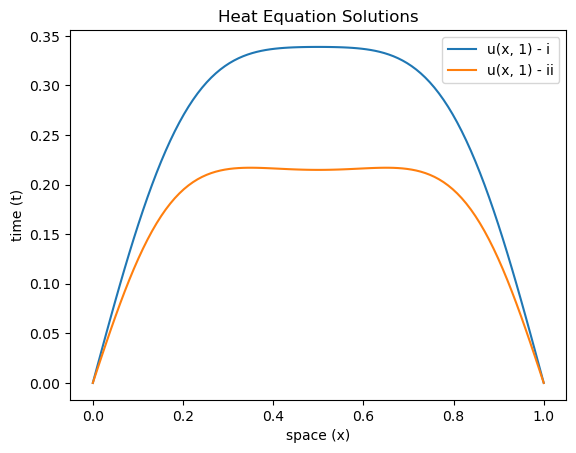

In [7]:
plt.plot(x_space, sol_traj_i, label='u(x, 1) - i')
plt.plot(x_space, sol_traj_ii, label='u(x, 1) - ii')
plt.title("Heat Equation Solutions")
plt.xlabel("space (x)")
plt.ylabel("time (t)")
plt.legend()
plt.show()

In [8]:
print("[u(1/4, 1) -  i]", exact_sol_i)
print("[u(1/4, 1) - ii]", exact_sol_ii)

[u(1/4, 1) -  i] 0.3018483883034014
[u(1/4, 1) - ii] 0.20939536385685037


In [9]:
def comp_ftcs(f, g, a, T, M, nu):
    h = 1 / M
    k = nu * (h ** 2) / a
    T_steps = int(T * a / (nu * (h ** 2)))
    x_space = np.linspace(0, 1, M+1)
    curr = g(x_space)

    for n in range(T_steps):
        # Finite differences
        up1 = nu * np.roll(curr, -1)
        up0 = (1 - 2 * nu) * curr
        um1 = nu * np.roll(curr, 1)
        f_vals = f(x_space, n * k)

        # Update step
        u_next = up1 + up0 + um1 + k * f_vals

        # Boundary conditions
        u_next[0], u_next[-1] = 0, 0

        # Move timestep
        curr = u_next

    return curr

In [10]:
def f_i(x, t):
    return np.zeros_like(x)

def f_ii(x, t):
    qx = np.sin(np.pi * x) / (2 - np.cos(2 * np.pi * x))
    sint = np.sin(np.pi * t)
    return qx * sint

def g_i(x):
    qx = np.sin(np.pi * x) / (2 - np.cos(2 * np.pi * x))
    return qx

def g_ii(x):
    return np.zeros_like(x)

def log_log_err_eval(f, g, comp_exact, fd_method, title=""):
    a = 1/100
    T = 1
    nu_1 = 1/6
    nu_2 = 1/3
    M_lst = [30, 60, 90, 120, 180, 240, 360, 480]
    n_quadrature = 100
    n_terms = 100

    errors_1 = []
    errors_2 = []
    for M in M_lst:
        h = 1 / M
        x_space = np.linspace(0, 1, M+1)
        sol = comp_exact(x_space, T, a, n_quadrature=n_quadrature, max_terms=n_terms)

        res1 = fd_method(f, g, a, T, M, nu_1)
        errors_1.append(np.sqrt(h * np.sum((res1 - sol) ** 2)))

        res2 = fd_method(f, g, a, T, M, nu_2)
        errors_2.append(np.sqrt(h * np.sum((res2 - sol) ** 2)))

    slope_approx1 = np.log(errors_1[-1] / errors_1[-2]) / np.log(M_lst[-1] / M_lst[-2])
    slope_approx2 = np.log(errors_2[-1] / errors_2[-2]) / np.log(M_lst[-1] / M_lst[-2])
    print(f"[nu=1/6] Slope:", slope_approx1)
    print(f"[nu=1/3] Slope:", slope_approx2)

    plt.plot(M_lst, errors_1, label=f'nu=1/6')
    plt.plot(M_lst, errors_2, label=f'nu=1/3')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('M')
    plt.ylabel('Error')
    plt.xticks([10, 100, 1000])
    plt.show()

[nu=1/6] Slope: -3.997174859782777
[nu=1/3] Slope: -2.0001118454287217


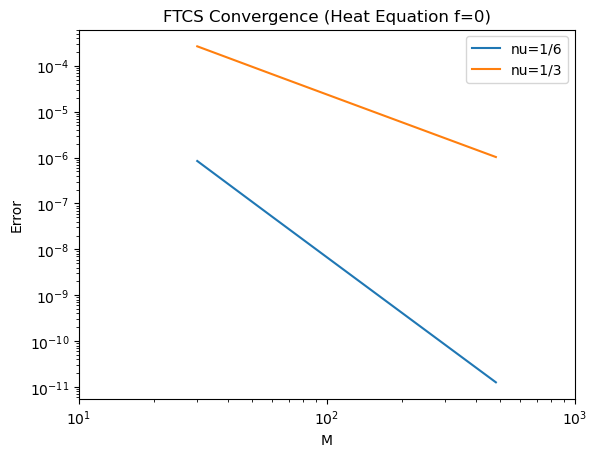

In [11]:
log_log_err_eval(f_i, g_i, comp_1ai_exact, comp_ftcs, title="FTCS Convergence (Heat Equation f=0)")

[nu=1/6] Slope: -1.9995605789106912
[nu=1/3] Slope: -1.9989605524784007


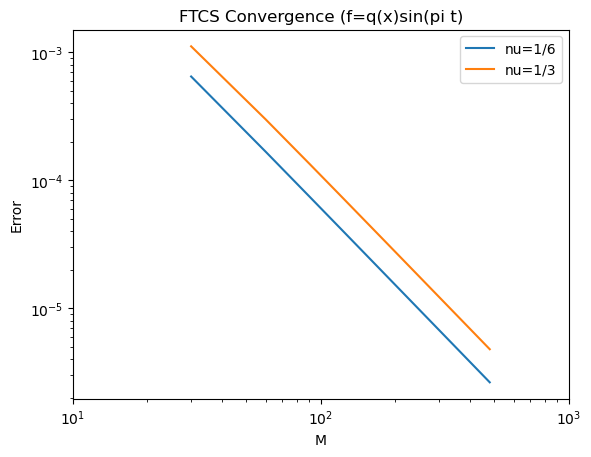

In [12]:
log_log_err_eval(f_ii, g_ii, comp_1aii_exact, comp_ftcs, title="FTCS Convergence (f=q(x)sin(pi t)")

In [13]:
def comp_ftcs2(f, g, a, T, M, nu):
    h = 1 / M
    k = nu * (h ** 2) / a
    T_steps = int(T * a / (nu * (h ** 2)))
    x_space = np.linspace(0, 1, M+1)
    curr = g(x_space)

    for n in range(T_steps):
        # Finite differences
        up1 = nu * np.roll(curr, -1)
        up0 = (1 - 2 * nu) * curr
        um1 = nu * np.roll(curr, 1)
        f0 = f(x_space, n * k)
        ftp1 = f(x_space, (n + 1) * k)
        fxp1 = np.roll(f0, -1)
        fxm1 = np.roll(f0, 1)
        f_vals = (1/3) * f0 + (1/2) * ftp1 + (1/12) * fxp1 + (1/12) * fxm1

        # Update step
        u_next = up1 + up0 + um1 + k * f_vals

        # Boundary conditions
        u_next[0], u_next[-1] = 0, 0

        # Move timestep
        curr = u_next

    return curr

[nu=1/6] Slope: -4.000305172917495
[nu=1/3] Slope: -1.9921656989110954


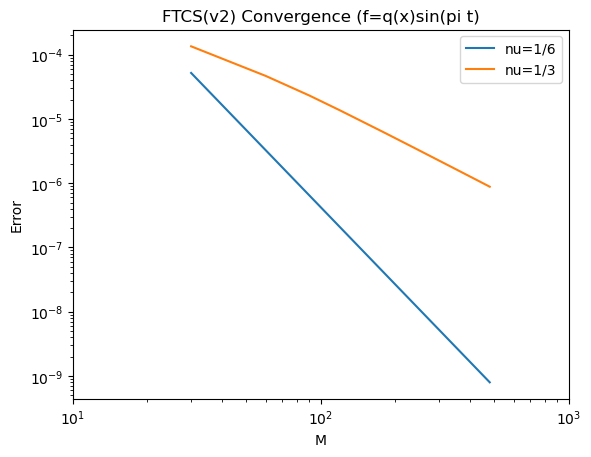

In [14]:
log_log_err_eval(f_ii, g_ii, comp_1aii_exact, comp_ftcs2, title="FTCS(v2) Convergence (f=q(x)sin(pi t)")

In [ ]:
# Problem 2

# u(x, t) = 1/2 e^2 - 1/2 cos(2 pi x) e^(1 - pi^2 / 5)t
# g(x) = sin^2(pi x)

def comp_2_exact(x, t, a):
    et = np.exp(t)
    cosx = np.cos(2 * np.pi * x)
    etpi = np.exp((1 - 4 * a * (np.pi ** 2)) * t)
    u = 0.5 * et - 0.5 * cosx * etpi
    return u

In [54]:
t = 1
a = 1/20

x_space = np.linspace(0, 1, 100)
sol_traj_2 = comp_2_exact(x_space, t, a)

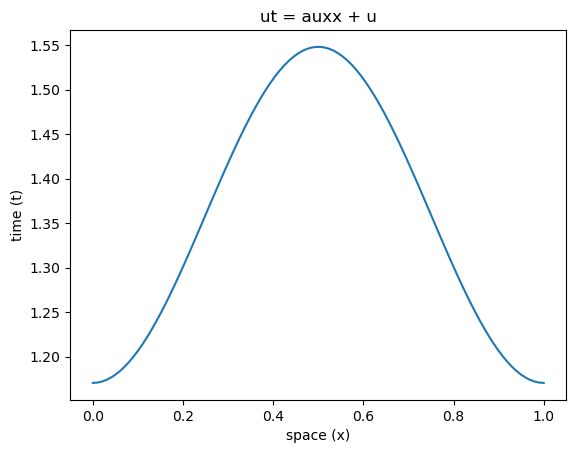

In [55]:
plt.plot(x_space, sol_traj_2, label='u(x, 1)')
plt.title("ut = auxx + u")
plt.xlabel("space (x)")
plt.ylabel("time (t)")
plt.show()

In [69]:
def log_log_err_eval2(g, comp_exact, fd_method, title=""):
    a = 1/20
    T = 1
    M_lst = [30, 60, 90, 120, 180, 240, 360, 480]
    nu = 1/6

    errors_1 = []
    for M in M_lst:
        h = 1 / M
        x_space = np.linspace(0, 1, M+1)
        sol = comp_exact(x_space, T, a)

        res1 = fd_method(g, a, T, M, nu)
        errors_1.append(np.sqrt(h * np.sum((res1 - sol) ** 2)))

    slope_approx1 = np.log(errors_1[-1] / errors_1[-2]) / np.log(M_lst[-1] / M_lst[-2])
    print(f"[nu=1/6] Slope:", slope_approx1)

    plt.plot(M_lst, errors_1, label=f'nu=1/3')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('M')
    plt.ylabel('Error')
    plt.xticks([10, 100, 1000])
    plt.show()

In [70]:
def comp_ftcs_prob2(g, a, T, M, nu):
    h = 1 / M
    k = nu * (h ** 2) / a
    T_steps = int(T * a / (nu * (h ** 2)))
    x_space = np.linspace(0, 1, M+1)
    init = g(x_space)
    init = np.hstack((init[0], init, init[-1]))
    curr = init
    # prev_curr = curr # Apply one step mesol_traj_2 = comp_2_exact(x_space, t, a)thod as prefill
    for _ in range(T_steps):
        # Finite differences
        up2 = (-1/12) * nu * np.roll(curr, -2)
        up1 = (4/3) * nu * np.roll(curr, -1)
        up0 = (-5/2) * nu * curr
        um1 = (4/3) * nu * np.roll(curr, 1)
        um2 = (-1/12) * nu * np.roll(curr, 2)

        # Update step
        u_next = up2 + up1 + up0 + um1 + um2 + k * curr + curr

        # Boundary conditions
        u_next[0], u_next[1] = u_next[2], u_next[2]
        u_next[-1], u_next[-2] = u_next[-3], u_next[-3]

        # Move timestep
        # prev_curr = curr
        curr = u_next

    return curr[1:-1]

def g_prob_2(x):
    return np.sin(np.pi * x) ** 2

In [71]:
print(sol_traj_2[:5])

[1.17034111 1.17072122 1.17186004 1.17375297 1.17639239]


[nu=1/6] Slope: -1.0046453507074782


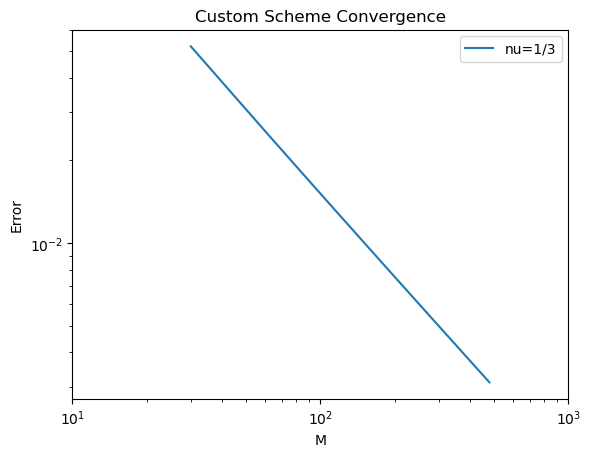

In [ ]:
log_log_err_eval2(g_prob_2, comp_2_exact, comp_ftcs_prob2, title="Custom Scheme Convergence")